# Quantum Phase Estimation
Quantum Phase Estimation is a simple algorithm for estimating the phase of an eigenvalue of a unitary operator if the corresponding eigenvector is known. Since eigenvalues of unitary operators have unit norm, a given unitary operator can be  fully characterized by this algorithm if its eigenvectors are known. We begin by importing the necessary qiskit libraries. We also define the relevant circuit parameters.

In [1]:
import numpy as np
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import U1Gate

In [2]:
# Define circuit parameters
phi = 0.43
u = '1010'
n = 7
k = len(u)

## Objective
We are given a unitary operator $U$ and one of its eigenvectors $|u\rangle$ such that

$$U|u\rangle = e^{2 \pi i \phi}|u\rangle$$

where $\phi \in [0,1]$. Our objective is to estimate the phase $\phi$.

## Prerequisites
Before we describe the circuit for Phase Estimation, we shall need to develop a theorem that we will have the need to invoke, while describing the circuit operation. This is done in the following.

### Theorem 1
This theorem describes the action of a series of Hadamard Transforms on a series of qubits initialized to $|0\rangle_n$. We claim that

$$H^{\otimes n}|0\rangle_n = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

where
1. $H^{\otimes n}$ is the $H$ operator applied individually to each of the $n$ qubits.
2. $|x\rangle_n$ is a shorthand for the $n$ bit binary representation of $x$. For example, $|3\rangle_4 = |0011\rangle$

#### Proof
$$\begin{align*}
H^{\otimes n}|0\rangle_n &= H|0\rangle \otimes H|0\rangle \otimes \cdots \otimes H|0\rangle \\
&= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \cdots \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}}\left(\left(|0\rangle + |1\rangle\right) \otimes \left(|0\rangle + |1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + |1\rangle\right) \right)
\end{align*}$$

Now, multiplying out the $\left(|0\rangle + |1\rangle\right)$ terms, we get a sum of all possible combinations of zeroes and ones. Thus, we get our final result,

$$H^{\otimes n}|0\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

## Circuit Description & Analysis
Next, we describe the circuit for Phase Estimation.

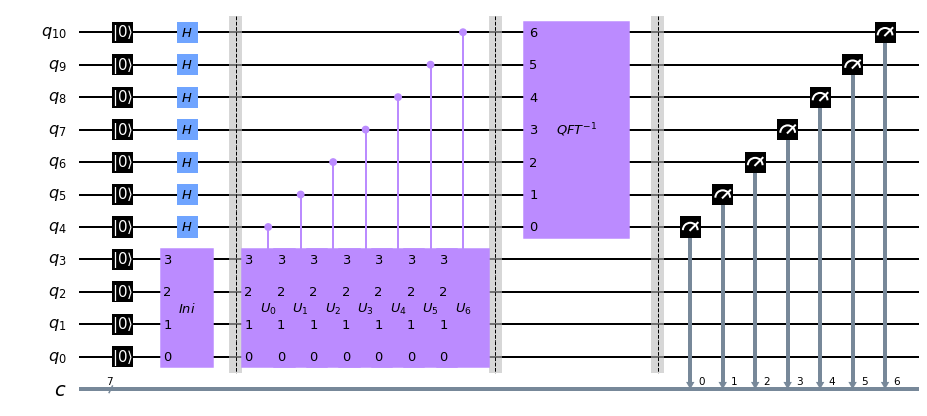

In [3]:
circ = QuantumCircuit(k+n, n)
circ.reset(range(k+n))
circ.h(range(k, k+n))
circ.append(Gate(name="$Ini$", num_qubits=k, params=[]), range(k))
circ.barrier()
for i in range(n):
    name = '$U_' + str(i) + '$'
    circ.append(QuantumCircuit(k, name=name).to_gate().control(1), [k+i, 0, 1, 2, 3])
circ.barrier()
circ.append(Gate(name="$QFT^{-1}$", num_qubits=n, params=[]), range(k, k+n))
circ.barrier()
circ.measure(range(k, k+n), range(n))
circ.draw('mpl', reverse_bits=True, scale=0.5)

Here, "Ini" refers to an initialization circuit that initializes the output register to the state $|u\rangle$. The $k$ qubit unitary operators $U_j$ are given by

$$U_j = U^{2^j}$$

where $U$ is the unitary operator whose eigenvalues are to be found. QFT refers to the $n$ qubit quantum fourier transform. Its operation is described as

$$QFT|x\rangle = \frac{1}{2^{n/2}} \sum_{y=0}^{2^n-1} e^{2 \pi i \frac{xy}{2^n}}|y\rangle$$

In the above circuit, we have marked out 3 barriers. We shall describe the circuit operation by evaluating the quantum state of the qubits at these barriers, which we shall number 1-3 from left to right.

### Barrier 1
We initialize the input register to zeros and the output register to $|u\rangle$. We apply an $H$ transform to the $n$ bit input register. By theorem 1 above, the state of the qubits is

$$\begin{align*}
|\psi_1\rangle &= H^{\otimes n}|0\rangle_n \otimes |u\rangle_{k} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes |u\rangle_{k}
\end{align*}$$

### Barrier 2
We apply a series of controlled $U_j$ gates to the output register, with the control qubit being the $j^{th}$ qubit $x_j$ of the input register. We thus get,

$$\begin{align*}
|\psi_2\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes U_0^{x_0}U_1^{x_1} \dots U_{n-1}^{x_{n-1}}|u\rangle_{k} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes U^{2^0 x_0 + 2^1 x_1 + \dots + 2^{n-1} x_{n-1}}|u\rangle_{k} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes U^x|u\rangle_{k} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} e^{2 \pi i \phi x}|x\rangle_n \otimes |u\rangle_{k} \\
\end{align*}$$

If $2^n \phi$ is an integer, we can write this as

$$\begin{align*}
|\psi_2\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} e^{2 \pi i \frac{(2^n \phi)(x)}{2^n}}|x\rangle_n \otimes |u\rangle_{k} \\
&= \left(QFT|2^n \phi\rangle_n\right) \otimes |u\rangle_{k} \\
\end{align*}$$


### Barrier 3
We apply an inverse $QFT$ to the input register. If $2^n \phi$ is an integer, we get the input register state as,

$$|\psi_3\rangle_n = |2^n \phi\rangle$$

If $2^n \phi$ is not an integer, we get a superposition of integer states with states whose values are close to $2^n \phi$, having larger probabilities.

### Measurement & Post Processing
We simply measure the input register. If $2^n \phi$ is an integer, we get its exact value, and thus, can calculate $\phi$ exactly, since $2^n$ is known. If $2^n \phi$ is not an integer, we get an integer close to it and still get a reasonable estimate. Multiple runs can and should be made in general to ensure that we get the right value.

## Qiskit Implementation
We shall need to implement three components before we perform any simulations.

1. The Initialization Circuit
2. The Operators $U_j$
3. The $QFT^{-1}$ Circuit

For the operator $U$, we shall choose a circuit which applies a phase of $2\pi\phi$ whenever the input state is $|u\rangle$. The variables $\phi$ and $u$ are defined at the beginning of the document. Initialization is easily achieved with a set of $X$ gates. The $U$ operator is essentially a controlled phase gate, from which $U_j$ is easily built via repeated applications.

For the QFT circuit, standard implementations can be found in almost all the standard textbooks on the subject. The inverse is easily obtained by reversing the order of operations and using the inverses of all the operations instead. We do not provide the theoretical details involved in implementation. We directly show the circuit instead, which can be easily verified to produce the desired transformation.

### Initialization

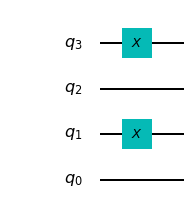

In [4]:
Ini = QuantumCircuit(k, name='Ini')
for i in range(k):
    if u[::-1][i] == '1':
        Ini.x(i)
Ini.draw('mpl', reverse_bits=True)

### $U_j$ Operators

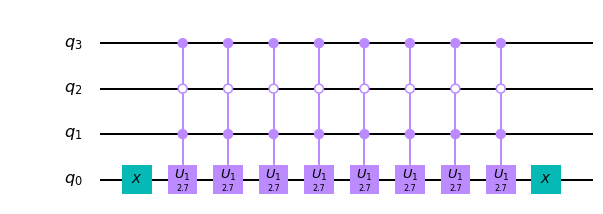

In [5]:
def Uop(j):
    p = 2 ** j
    U = QuantumCircuit(k, name='U'+str(j))
    if u[k-1] == '0':
        U.x(0)
    for i in range(p):
        U.append(U1Gate(2*pi*phi).control(k-1, ctrl_state=u[0:k-1][::-1]), reversed(range(k)))
    if u[k-1] == '0':
        U.x(0)
    return U

Uop(3).draw('mpl',reverse_bits=True)

### Inverse Quantum Fourier Transform

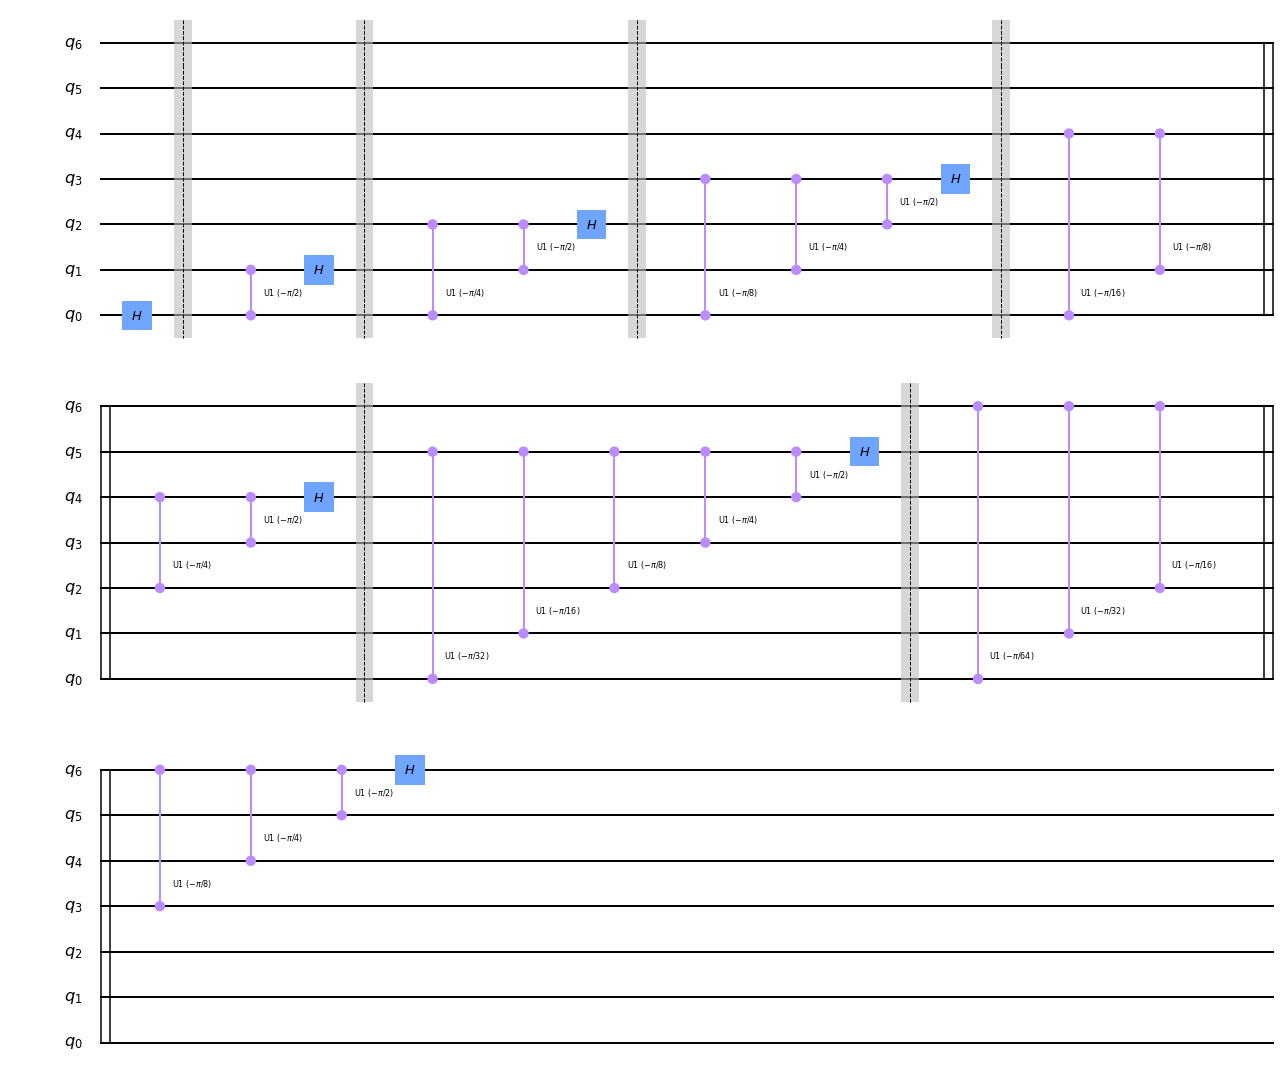

In [6]:
QFT_inv = QuantumCircuit(n, name='QFT^{-1}')
for i in range(n):
    if i != 0:
        QFT_inv.barrier()
    for j in range(i):
        QFT_inv.cu1(-pi/(2 ** (i-j)), i, j)
    QFT_inv.h(i)
QFT_inv.draw('mpl', reverse_bits=True)

## QASM Simulation
Now, we complete the circuit for Phase Estimation and run a full QASM simulation.

In [7]:
circ = QuantumCircuit(k+n, n)
circ.reset(range(k+n))
circ.h(range(k, k+n))
circ.append(Ini.to_instruction(), range(k))
circ.barrier()
for i in range(n):
    circ.append(Uop(i).to_gate().control(1), [k+i]+list(range(k)))
circ.barrier()
circ.append(QFT_inv.to_instruction(), range(k, k+n))
circ.barrier()
circ.measure(range(k, k+n), range(n))
circ.draw(reverse_bits=True, scale=0.5)

┌───┐   ░                                                   ░ »
q_10: ─|0>──┤ H ├───░──────────────────────────────────────────────■────░─»
            ├───┤   ░                                              │    ░ »
 q_9: ─|0>──┤ H ├───░───────────────────────────────────────■──────┼────░─»
            ├───┤   ░                                       │      │    ░ »
 q_8: ─|0>──┤ H ├───░────────────────────────────────■──────┼──────┼────░─»
            ├───┤   ░                                │      │      │    ░ »
 q_7: ─|0>──┤ H ├───░─────────────────────────■──────┼──────┼──────┼────░─»
            ├───┤   ░                         │      │      │      │    ░ »
 q_6: ─|0>──┤ H ├───░──────────────────■──────┼──────┼──────┼──────┼────░─»
            ├───┤   ░                  │      │      │      │      │    ░ »
 q_5: ─|0>──┤ H ├───░───────────■──────┼──────┼──────┼──────┼──────┼────░─»
            ├───┤   ░           │      │      │      │      │      │    ░ »
 q_4: ─|0>──┤ H ├───░────■──────┼──────┼──────┼──────┼──────┼──────┼────░─»
           ┌┴───┴─┐ ░ ┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐ ░ »
 q_3: ─|0>─┤3     ├─░─┤3 │  ├┤3 │  ├┤3 │  ├┤3 │  ├┤3 │  ├┤3 │  ├┤3 │  ├─░─»
           │      │ ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_2: ─|0>─┤2     ├─░─┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├─░─»
           │  Ini │ ░ │  U0 ││  U1 ││  U2 ││  U3 ││  U4 ││  U5 ││  U6 │ ░ »
 q_1: ─|0>─┤1     ├─░─┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├─░─»
           │      │ ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_0: ─|0>─┤0     ├─░─┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├─░─»
           └──────┘ ░ └─────┘└─────┘└─────┘└─────┘└─────┘└─────┘└─────┘ ░ »
 c_6: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_5: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_4: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_3: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_2: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_1: ════════════════════════════════════════════════════════════════════»
                                                                          »
 c_0: ════════════════════════════════════════════════════════════════════»
                                                                          »
«      ┌───────────┐ ░                   ┌─┐
«q_10: ┤6          ├─░───────────────────┤M├
«      │           │ ░                ┌─┐└╥┘
« q_9: ┤5          ├─░────────────────┤M├─╫─
«      │           │ ░             ┌─┐└╥┘ ║ 
« q_8: ┤4          ├─░─────────────┤M├─╫──╫─
«      │           │ ░          ┌─┐└╥┘ ║  ║ 
« q_7: ┤3 QFT^{-1} ├─░──────────┤M├─╫──╫──╫─
«      │           │ ░       ┌─┐└╥┘ ║  ║  ║ 
« q_6: ┤2          ├─░───────┤M├─╫──╫──╫──╫─
«      │           │ ░    ┌─┐└╥┘ ║  ║  ║  ║ 
« q_5: ┤1          ├─░────┤M├─╫──╫──╫──╫──╫─
«      │           │ ░ ┌─┐└╥┘ ║  ║  ║  ║  ║ 
« q_4: ┤0          ├─░─┤M├─╫──╫──╫──╫──╫──╫─
«      └───────────┘ ░ └╥┘ ║  ║  ║  ║  ║  ║ 
« q_3: ──────────────░──╫──╫──╫──╫──╫──╫──╫─
«                    ░  ║  ║  ║  ║  ║  ║  ║ 
« q_2: ──────────────░──╫──╫──╫──╫──╫──╫──╫─
«                    ░  ║  ║  ║  ║  ║  ║  ║ 
« q_1: ──────────────░──╫──╫──╫──╫──╫──╫──╫─
«                    ░  ║  ║  ║  ║  ║  ║  ║ 
« q_0: ──────────────░──╫──╫──╫──╫──╫──╫──╫─
«                    ░  ║  ║  ║  ║  ║  ║  ║ 
« c_6: ═════════════════╬══╬══╬══╬══╬══╬══╩═
«                       ║  ║  ║  ║  ║  ║    
« c_5: ═════════════════╬══╬══╬══╬══╬══╩════
«                       ║  ║  

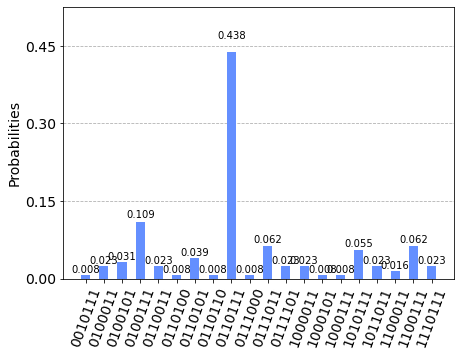

In [8]:
delta = 128
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator, shots=delta).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [ ]:
x = list(counts.keys())
x = [int(i, 2)/(2 ** n) for i in x]
p = list(counts.values())
p = p.index(max(p))
phi_estimate = x[p]
print('Estimated phase:')
print(phi_estimate)
print('Actual Phase:')
print(phi)

Estimated phase:
0.4296875
Actual Phase:
0.43


Thus, one can accurately estimate the phase $\phi$. The accuracy can be further increased by increasing the number of qubits $n$ in the input register.

## References
1. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
2. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/